In [6]:
pip install google-cloud-storage pandas matplotlib seaborn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.8/789.8 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]
Note: you may need to restart the kernel to use updated packages.


## Load data

In [3]:
from google.cloud import storage
import pandas as pd
import json
import io

BUCKET_NAME = 'news-category-dataset'
FILE_NAME = 'News_Category_Dataset_v3.json'

client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)
blob = bucket.blob(FILE_NAME)

# Download the file as bytes and decode to string
data_str = blob.download_as_string().decode('utf-8')

# Each line is a standalone JSON object
records = []
for line in data_str.splitlines():
    if line.strip():  # skip empty lines
        records.append(json.loads(line))

# Load into pandas DataFrame
df = pd.DataFrame(records)
print(df.head())
print(df.columns)

                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog y

## EDA

DataFrame shape: (209527, 6)
Sample records:
                                                 link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...      

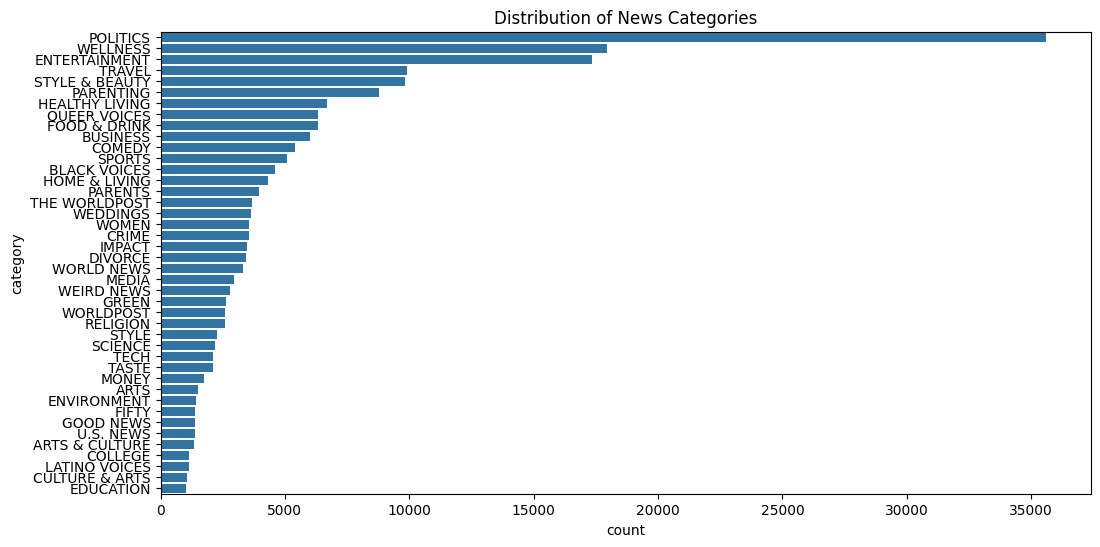

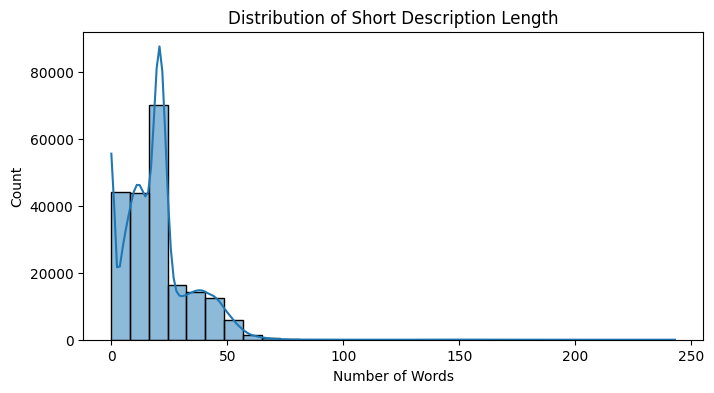

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic info
print("DataFrame shape:", df.shape)
print("Sample records:\n", df.head())

# Check for missing values
print("Missing values by column:\n", df.isnull().sum())

# Distribution of categories
plt.figure(figsize=(12,6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Distribution of News Categories')
plt.show()

# Description length analysis
df['desc_length'] = df['short_description'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
sns.histplot(df['desc_length'], bins=30, kde=True)
plt.title('Distribution of Short Description Length')
plt.xlabel('Number of Words')
plt.show()

In [7]:
import nltk
from collections import Counter
from nltk.corpus import stopwords
import string

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=10):
    words = []
    for txt in texts:
        words.extend([
            word.lower() for word in txt.split()
            if word.lower() not in stop_words and word not in string.punctuation
        ])
    return Counter(words).most_common(n)

# Get top words for the first 5 categories
categories = df['category'].unique()[:5]
for cat in categories:
    top_words = get_top_words(df[df['category']==cat]['short_description'])
    print(f"Top words for category '{cat}':")
    for word, count in top_words:
        print(f"{word}: {count}")
    print("-" * 30)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top words for category 'U.S. NEWS':
said: 158
new: 106
police: 87
people: 86
u.s.: 67
one: 64
said.: 60
two: 54
last: 45
state: 44
------------------------------
Top words for category 'COMEDY':
like: 246
one: 218
host: 195
new: 156
night: 145
get: 142
time: 137
show": 136
people: 131
know: 124
------------------------------
Top words for category 'PARENTING':
--: 1107
kids: 850
one: 826
children: 806
like: 666
parents: 664
time: 598
child: 517
know: 498
new: 496
------------------------------
Top words for category 'WORLD NEWS':
said: 248
people: 201
u.s.: 200
president: 193
one: 130
new: 126
two: 119
said.: 117
trump: 108
killed: 102
------------------------------
Top words for category 'CULTURE & ARTS':
art: 111
new: 94
--: 66
one: 64
artist: 58
work: 56
like: 53
x: 53
world: 44
two: 41
------------------------------


In [8]:
pip install google-cloud-language


Note: you may need to restart the kernel to use updated packages.


## Entity/key information extraction

In [9]:
from google.cloud import language_v1

# Initialize client
client = language_v1.LanguageServiceClient()

def extract_entities(text):
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    response = client.analyze_entities(document=document)
    entities = [(entity.name, language_v1.Entity.Type(entity.type_).name) for entity in response.entities]
    return entities

def extract_sentiment(text):
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    response = client.analyze_sentiment(document=document)
    return response.document_sentiment.score

# Example usage for first 5 rows
for idx, row in df.head(5).iterrows():
    print(f"Headline: {row['headline']}")
    print(f"Entities: {extract_entities(row['short_description'])}")
    print(f"Sentiment: {extract_sentiment(row['short_description'])}")
    print("-"*40)

Headline: Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters
Entities: [('Health experts', 'PERSON'), ('doses', 'OTHER'), ('demand', 'OTHER'), ('fall', 'OTHER'), ('U.S.', 'LOCATION'), ('boosters', 'PERSON'), ('171 million', 'NUMBER')]
Sentiment: -0.30000001192092896
----------------------------------------
Headline: American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video
Entities: [('passengers', 'PERSON'), ('crew', 'PERSON'), ('back', 'OTHER'), ('aircraft', 'OTHER'), ('confrontation', 'EVENT'), ('office', 'ORGANIZATION'), ('attorney', 'PERSON'), ('Los Angeles', 'LOCATION'), ('U.S.', 'LOCATION')]
Sentiment: -0.30000001192092896
----------------------------------------
Headline: 23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23)
Entities: [('dog', 'OTHER')]
Sentiment: -0.20000000298023224
----------------------------------------
Headline: The Funniest Tweets From Parents This Week (Sept. 17-23)
Entities: [('t

In [10]:
pip install google-cloud-aiplatform

Note: you may need to restart the kernel to use updated packages.


## Summarization

In [12]:
from vertexai.preview.generative_models import GenerativeModel

model = GenerativeModel('gemini-2.5-pro')

def summarize_text(text):
    prompt = f"Summarize the following news description in one sentence:\n{text}"
    response = model.generate_content(prompt)
    return response.text

# Summarize first 5 news descriptions
for idx, row in df.head(5).iterrows():
    print(f"Original: {row['short_description']}")
    print(f"Summary: {summarize_text(row['short_description'])}")
    print("-"*40)

Original: Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
Summary: Health experts are uncertain if public demand for the new fall boosters will match the 171 million doses ordered by the U.S. government.
----------------------------------------
Original: He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.
Summary: Passengers and crew subdued a man after he fled to the back of the aircraft following a confrontation.
----------------------------------------
Original: "Until you have a dog you don't understand what could be eaten."
Summary: Dogs are known for eating a surprising variety of inedible objects, a lesson their owners often learn from experience.
----------------------------------------
Original: "Accidentally put grown-up toothpaste on my toddler’s toothbrush and he

## Comparison with traditional NLP baselines

In [14]:
pip install spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 99.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.1/795.1 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 135.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [spacy]m18/19 [spacy]tion]ta]
Note: you may need to restart the kernel to use updated packages.


In [16]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Example:
for idx, row in df.head(5).iterrows():
    print(f"SpaCy Entities: {spacy_entities(row['short_description'])}")

SpaCy Entities: [('171 million', 'CARDINAL'), ('U.S.', 'GPE')]
SpaCy Entities: [('U.S.', 'GPE'), ('Los Angeles', 'GPE')]
SpaCy Entities: []
SpaCy Entities: [('Tabasco', 'GPE')]
SpaCy Entities: [('Amy Cooper', 'PERSON'), ('Franklin Templeton', 'PERSON'), ('Central Park', 'LOC')]


In [20]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 119.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.11.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
geopandas 1.1.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.


In [ ]:
!pip install numpy==1.23.5

In [22]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 121.8 MB/s eta 0:00:00
  DEPRECATION: Building 'docopt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'docopt'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13781 sha256=1ef93e4e547b835b7fcee9fee57ecaf9160b675329d5cf5ae659e67ae57aa039
  Stored in directory: /home/jupyter/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  DEPRECATION: Building 'breadability'

In [24]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [25]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

def sumy_textrank_summary(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return " ".join(str(sentence) for sentence in summary)

# Example
for idx, row in df.head(5).iterrows():
    print(f"Original: {row['short_description']}")
    print(f"Sumy TextRank Summary: {sumy_textrank_summary(row['short_description'])}")
    print("-" * 40)

Original: Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
Sumy TextRank Summary: Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
----------------------------------------
Original: He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.
Sumy TextRank Summary: He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.
----------------------------------------
Original: "Until you have a dog you don't understand what could be eaten."
Sumy TextRank Summary: "Until you have a dog you don't understand what could be eaten."
----------------------------------------
Original: "Acciden